# "ArviZ customization with rcParams"
> "Use ArviZ rcParams to get sensible defaults right out of the box"

- toc: true
- author: Oriol Abril
- badges: true
- categories: [arviz, customization, rcparams]
- image: images/nb/rc_context.png

# About
ArviZ not only builds on top of matplotlib's `rcParams` but also adds its own rcParams instance to handle specific settings. This post will only graze matplotlib's rcParams, which are already detailed in [matplotlib's docs](https://matplotlib.org/1.4.1/users/customizing.html); it will dive into specific ArviZ rcParams.

# Introduction
Paraphrasing the description on rcParams in the documentation of matplotlib:

> ArviZ uses arvizrc configuration files to customize all kinds of properties, which we call rcParams. You can control the defaults of many properties in ArviZ: data loading mode (lazy or eager), automatically showing generated plots, the default information criteria and so on.

There are several ways of modifying `arviz.rcParams` instance, each of them targeted to specific needs.

In [1]:
import arviz as az
import matplotlib.pyplot as plt

idata = az.load_arviz_data("centered_eight")

# Customizing ArviZ

## arvizrc file
To define default values on a per user or per project basis, `arvizrc` file should be used. When imported, ArviZ search for an `arvizrc` file in several locations sorted below by priority:
- `$PWD/arvizrc`
- `$ARVIZ_DATA/arvizrc`
- On Linux,
  - `$XDG_CONFIG_HOME/arviz/arvizrc` (if `$XDG_CONFIG_HOME`
  is defined)
  - or `$HOME/.config/arviz/arvizrc` (if `$XDG_CONFIG_HOME`
  is not defined)
- On other platforms,
  - `$HOME/.arviz/arvizrc` if `$HOME` is defined
    
Once one of these files is found, ArviZ stops looking and loads its configuration. If none of them are present, the values hardcoded in ArviZ codebase are used. The file used to set the default values in ArviZ can be obtained with the following command:

In [2]:
import arviz as az
print(az.rcparams.get_arviz_rcfile())

/home/oriol/.config/arviz/arvizrc


ArviZ has loaded a file used to set defaults on a per user basis. Unless I use a different rc file in the current directory or modify `rcParams` as explained above, this configuration will be automatically used every time ArviZ is imported. 

This can be really useful to define the favourite backend or information criterion, written once in the rc file and ArviZ automatically uses the desired values.

> Important: You should not rely on ArviZ defaults being always the same.

ArviZ strives to encourage best practices and therefore will change the default values whenever a new algorithm is developed to achieve this goal. If you rely on a specific value, you should either use an `arvizrc` template or set the defaults at the beggining of every script/notebook.

## Dynamic rc settings
To set default values on a per file or per project basis, `rcParams` can also be modified dynamically, either overwritting a specific key:

In [3]:
az.rcParams["data.load"] = "eager"

Note that `rcParams` is the instance to be modified, exactly like in matplotlib. Careful with capitalization!

Another option is to define a dictionary with several new defaults and update rcParams all at once. 

In [4]:
rc = {
    "data.load": "lazy",
    "plot.max_subplots": 30,
    "stats.ic_scale": "negative_log",
    "plot.matplotlib.constrained_layout": False
}
az.rcParams.update(rc)

## rc_context
And last but not least, to temporarily use a different set of defaults, ArviZ also has a [`rc_context`](https://arviz-devs.github.io/arviz/generated/arviz.rc_context.html#arviz.rc_context) function. Its main difference and advantage is that it is a context manager, therefore, all code executed inside the context will use the defaults defined by `rc_context` but once we exit the context, everything goes back to normal. Let's generate 3 posterior plots with the same command to show this:

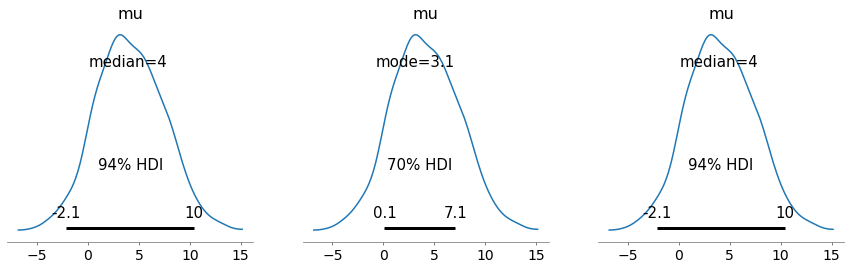

In [5]:
_, axes = plt.subplots(1,3, figsize=(15,4))

az.plot_posterior(idata, var_names="mu", ax=axes[0])

with az.rc_context({"plot.point_estimate": "mode", "stats.hdi_prob": 0.7}):
    az.plot_posterior(idata, var_names="mu", ax=axes[1])

az.plot_posterior(idata, var_names="mu", ax=axes[2]);

# ArviZ default settings
This section will describe ArviZ rcParams as version 0.8.3 (see [GitHub](https://github.com/arviz-devs/arviz/blob/master/arvizrc.template) for an up to date version).

## Data
The rcParams in this section are related to the [data](https://arviz-devs.github.io/arviz/api.html#data) module in ArviZ, that is, they are either related to `from_xyz` converter functions or to `InferenceData` class.

**data.http_protocol** : *{https, http}*

Only the first two example datasets `centered_eight` and `non_centered_eight` come as part of ArviZ. All the others are downloaded from figshare the first time and stored locally to help reloading them the next time. We can get the names of the data available by not passing any argument to `az.load_arviz_data` (you can also get the description of each of them with `az.list_datasets`):

In [6]:
az.load_arviz_data().keys()

dict_keys(['centered_eight', 'non_centered_eight', 'radon', 'rugby', 'regression1d', 'regression10d', 'classification1d', 'classification10d'])

Thus, the first time you call `az.load_arviz_data("radon")`, ArviZ downloads the dataset using `data.http_protocol`. The default is set to `https` but if needed, it can be modified to `http`. Notice how there is no fallback, if downloading with `https` fails, there is no second try with `http`, an error is risen. To use `http` you have to set the rcParam explicitly.



**data.index_origin** : *{0, 1}*

ArviZ integration with Stan and Julia who use 1 based indexing motivate this rcParam. This rcParam is still at an early stage and its implementation is bound to vary, therefore it has no detailed description.

**data.load** : *{lazy, eager}*

Even when not using Dask, xarray's default is to load data lazily into memory when reading from disk. ArviZ's `from_netcdf` also uses the same default. That is, ArviZ functions that read data from disk `from_netcdf` and `load_arviz_data` do not load the data into memory unless `data.load` rcParam is set to `eager`. 

Most use cases not only do not require loading data into memory but will also benefit from lazy loading. However, there is one clear exception: when too many files are lazily opened at the same time, xarray ends up crashing with extremely cryptic error messages, these cases require setting data loading to eager mode. One example of such situation is generating ArviZ documentation, we therefore set `data.load` to `eager` in sphinx configuration file.

**data.metagroups** : *mapping of {str : list of str}*

> Warning: Do not overwrite `data.metagroups` as things may break, to add custom metagroups add new keys to the dictionary as shown below

One of the current projects in ArviZ is to extend the capabilities of `InferenceData`. One of the limitations was not allowing its functions and methods to be applied to several groups at the same time. Starting with ArviZ 0.8.0, [`InferenceData` methods](https://arviz-devs.github.io/arviz/generated/arviz.InferenceData.html#arviz.InferenceData) take arguments `groups` and `filter_groups` to overcome this limitation. These two combined arguments have the same capabilities as `var_names`+`filter_vars` in plotting functions: exact matching, like and regex matching like pandas and support for ArviZ `~` negation prefix and one extra feature: metagroups. So what are metagroups? Let's see

In [7]:
#collapse-hide
for metagroup, groups in az.rcParams["data.metagroups"].items():
    print(f"{metagroup}:\n    {groups}\n")

posterior_groups:
    ('posterior', 'posterior_predictive', 'sample_stats', 'log_likelihood')

prior_groups:
    ('prior', 'prior_predictive', 'sample_stats_prior')

posterior_groups_warmup:
    ('_warmup_posterior', '_warmup_posterior_predictive', '_warmup_sample_stats')

latent_vars:
    ('posterior', 'prior')

observed_vars:
    ('posterior_predictive', 'observed_data', 'prior_predictive')



Imagine the data you passed to the model was rescaled, after converting to `InferenceData` you have to rescale the data again to its original values, but not only the observations, posterior and prior predictive values too! 

Having to apply the rescaling manually to each of the three groups is tedious at best, and creating a variable called `observed_vars` storing a list with these 3 groups is problematic -- when doing prior checks there is no `posterior_predictive` group, it's a highway towards errors at every turn. Metagroups are similar to the variable approach but it's already there and it applies the function only to present groups. Let's add a new metagroup and use it to shift our data:

In [8]:
az.rcParams["data.metagroups"]["sampled"] = (
    'posterior', 'posterior_predictive', 'sample_stats', 'log_likelihood', 'prior', 'prior_predictive'
)
shifted_idata = idata.map(lambda x: x-7, groups="sampled")

**data.save_warmup** : *bool*

If `True`, converter functions will store warmup iterations in the corresponding groups by default.

> Note: `data.save_warmup` does not affect `from_netcdf`, all groups are always loaded from file

---

## Plot

### General

**plot.backend** : *{matplotlib, bokeh}*

Default plotting backend.

**plot.max_subplots** : int

Maximum number of subplots in a single figure. Adding too many subplots into a figure can be really slow, to the point that it looks like everthing has crashed without any error message. When there are more variables to plot than `max_subplots` allowed, ArviZ sends a warning and plots at most `max_suplots`. See for yourselves:

/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/arviz/plots/plot_utils.py:563: UserWarning: rcParams['plot.max_subplots'] (3) is smaller than the number of variables to plot (10) in plot_posterior, generating only 3 plots
  UserWarning,


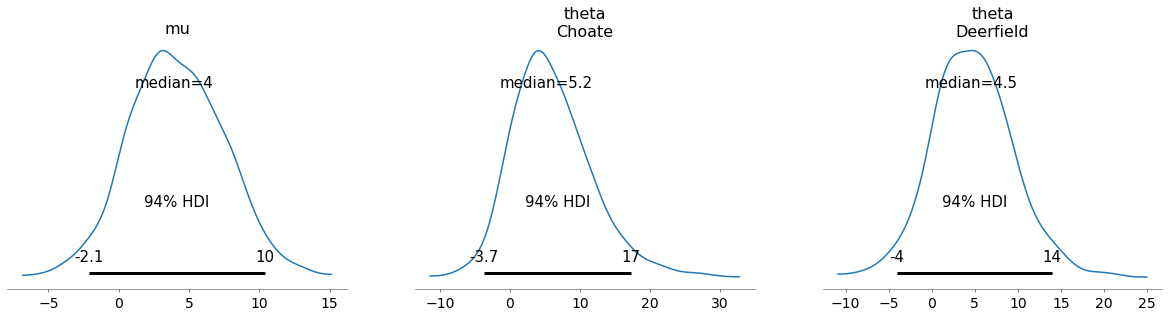

In [9]:
with az.rc_context({"plot.max_subplots": 3}):
    az.plot_posterior(idata);

**plot.point_estimate** : *{mean, median, model, None}*

Default point estimate to include in plots like `plot_posterior` or `plot_density`. 

### Bokeh

**plot.bokeh.bounds_x_range**, **plot.bokeh.bounds_y_range** : *auto, None or tuple of (float, float), default auto*


**plot.bokeh.figure.dpi** : *int, default 60*

**plot.bokeh.figure.height**, **plot.bokeh.figure.width** : *int, default 500*

**plot.bokeh.layout.order** : *str, default default*

Select subplot structure for bokeh. One of `default`, `column`, `row`, `square`, `square_trimmed` or `Ncolumn` (`Nrow`) where N is an integer number of columns (rows), here is one example to generate a subplot grid with 2 columns and the necessary rows to fit all variables.

In [10]:
with az.rc_context({"plot.bokeh.layout.order": "2column"}):
    az.plot_ess(idata, backend="bokeh")

**plot.bokeh.layout.sizing_mode** : *{fixed, stretch_width, stretch_height, stretch_both, scale_width, scale_height, scale_both}*

**plot.bokeh.layout.toolbar_location** : *{above, below, left, right, None}*

Location for toolbar on bokeh layouts. `None` will hide the toolbar.

**plot.bokeh.marker** : *str, default Cross*

Default marker for bokeh plots. See [bokeh reference on markers](https://docs.bokeh.org/en/latest/docs/reference/models/markers.html) for more details.

**plot.bokeh.output_backend** : *{webgl, canvas, svg}*

**plot.bokeh.show** : *bool, default True*

Show bokeh plot before returning in ArviZ function.

**plot.bokeh.tools** : *str, default reset,pan,box_zoom,wheel_zoom,lasso_select,undo,save,hove*

Default tools in bokeh plots. More details on [Configuring Plot Tools docs](https://docs.bokeh.org/en/latest/docs/user_guide/tools.html)

### Matplotlib
Matplotlib already has its own [`rcParams`](https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html#a-sample-matplotlibrc-file), which are actually the inspiration for ArviZ rcParams. Therefore, this section is minimalistic.

**plot.matplotlib.show** : *bool, default False*

Call `plt.show` from within ArviZ plotting functions. This generally makes no difference in jupyter like environments, but it can be useful for instance in the IPython terminal when we don't want to customize the plots genereted by ArviZ by changing titles or labels.

---

## Stats

**stats.hdi_prob** : *float*

Default probability of the calculated HDI intervals.

> Important: This probability is completely arbitrary. ArviZ using 0.94 instead of the more common 0.95 aims to emphasize this arbitrary choice.

**stats.information_criterion** : *{loo, waic}*

Default information criterion used by `compare` and `plot_elpd`

**stats.ic_pointwise** : *bool, default False*

Return pointwise values when calling `loo` or `waic`. Pointwise values are an intermediate result and therefore setting `ic_pointwise` to true does not require extra computation.

**stats.ic_scale** : *{log, deviance, negative_log}*

Default information criterion scale. See docs on [`loo`](https://arviz-devs.github.io/arviz/generated/arviz.loo.html#arviz.loo) or [`waic`](https://arviz-devs.github.io/arviz/generated/arviz.waic.html#arviz.waic) for more detail.

---

> Tip: Is there any extra rcParam you'd like to see in ArviZ? Check out [arviz-devs/arviz#792](https://github.com/arviz-devs/arviz/issues/792), it's more than possible you'll be able to add it yourself!

---
Comments are not enabled for the blog, to inquiry further about the contents of the post, ask on [ArviZ Issues](https://github.com/arviz-devs/arviz/issues).